In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import namedtuple
import os
from time import time, sleep
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
import torchvision.transforms as transforms

import opacus
from opacus import PrivacyEngine
from opacus.validators import ModuleValidator

from utils import generate_run_id, get_input_args, Args, parse_run_id
from models import Discriminator_FC, Generator_MNIST, Weight_Clipper, G_weights_init, Generator_FC
from data import load_MNIST
from metrics import get_IS, get_FID

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
def generate_samples(G, args):
    # G = Generator_MNIST(nz=args.nz, ngf=args.ngf, nc=args.nc).to(device)
    # Generate Sample Images
    noise = torch.randn(32, args.nz).to(device)
    print(noise.shape)
    fake = G(noise)
    fake = fake.view(fake.size(0), 1, 28, 28)
    print(torch.min(fake), torch.max(fake))

    # Plot Sample Images
    fig, ax = plt.subplots(4, 8, figsize=(10, 5))
    for i in range(4):
        for j in range(8):
            ax[i, j].imshow(fake[i*8+j][0].detach().cpu().numpy(), cmap='gray')
            ax[i, j].axis('off')
    plt.show()
    # Close Figure
    plt.close()

Loading runs_gen_fc_3/public_128_100_32_1_inf_1e-06_0.0_0.01_5e-05_0.0_64_3_500000_LeakyReLU_0.0/netG_100000.pt
[128]
torch.Size([32, 100])
tensor(3.1483e-06, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9998, device='cuda:0', grad_fn=<MaxBackward1>)


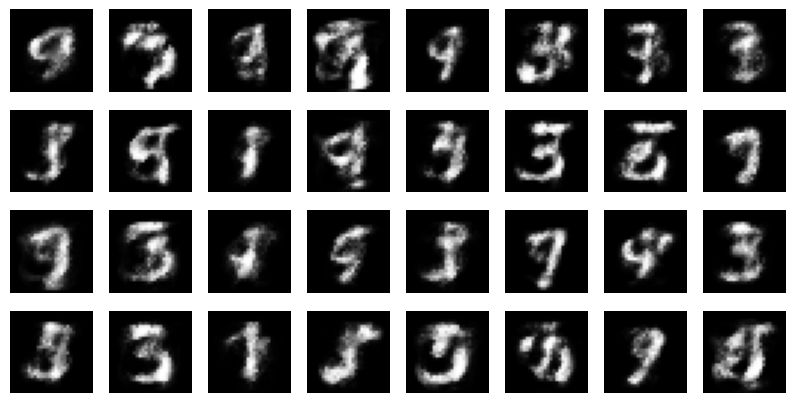

Loading runs_gen_fc_3/public_128_100_32_1_inf_1e-06_0.0_0.01_5e-05_0.0_64_3_500000_LeakyReLU_0.0/netG_110000.pt
[128]
torch.Size([32, 100])
tensor(2.1590e-07, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9999, device='cuda:0', grad_fn=<MaxBackward1>)


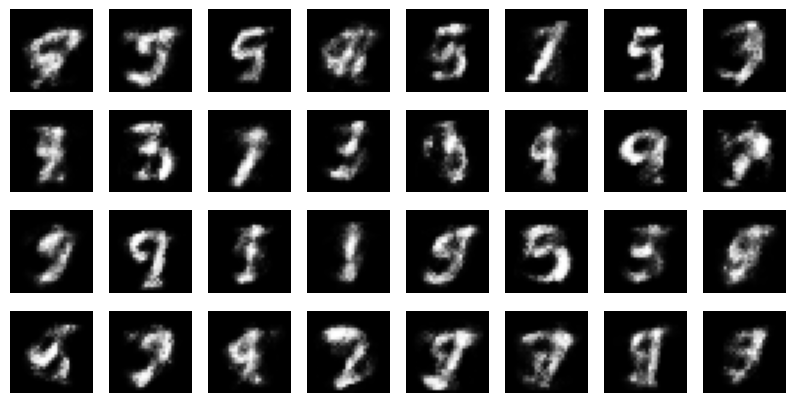

Loading runs_gen_fc_3/public_128_100_32_1_inf_1e-06_0.0_0.01_5e-05_0.0_64_3_500000_LeakyReLU_0.0/netG_120000.pt
[128]
torch.Size([32, 100])
tensor(2.5271e-06, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9998, device='cuda:0', grad_fn=<MaxBackward1>)


KeyboardInterrupt: 

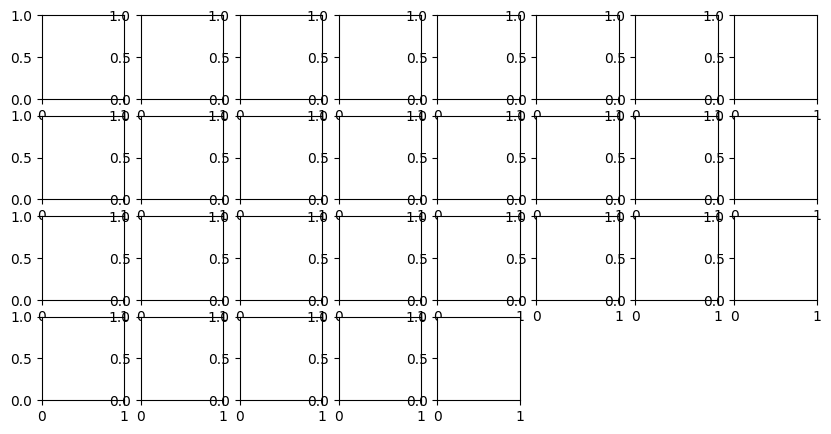

In [17]:
# Load the generator
# run_id = "/home/jason/p2/runs/private_16-12_100_32_1_inf_1e-06_0.0_0.01_0.0001_0.5_64_5_200000_LeakyReLU" # decent
run_id = "/home/jason/p2/runs/private_16-12_100_32_1_inf_1e-06_0.4_0.005_0.0001_0.5_64_4_500000_LeakyReLU" # better
run_id = "/home/jason/p2/runs/16-12_100_32_1_38.0_1e-06_0.05_0.01_0.0001_0.5_64_5_200000_LeakyReLU" # somewhat reasonable noised
run_id = "/home/jason/p2/runs_gen_fc_3/public_128_100_32_1_inf_1e-06_0.0_0.01_5e-05_0.0_64_3_500000_LeakyReLU_0.0"

run_id = run_id.split("/")[-1]
run_fp = os.path.join('runs_gen_fc_3/', run_id)
args = parse_run_id(run_id)

for i in range(100000, 500000 + 1, 10000):
    gen_fp = os.path.join(run_fp, 'netG_{}.pt'.format(i))
    if os.path.exists(gen_fp):
        print("Loading {}".format(gen_fp))

        G = Generator_FC([128], args.nz).to(device)
        G.load_state_dict(torch.load(gen_fp))
        G.eval()

        generate_samples(G, args)

In [ ]:
# Random Seeding
torch.manual_seed(0)
np.random.seed(0)


activation = 'LeakyReLU'
args = Args(
    # Model Parameters
    hidden=[16, 12], nz=100, ngf=32, nc=1, activation=activation,
    # Privacy Parameters
    epsilon=50.0, delta=1e-6, noise_multiplier=0.3, c_p=0.01, 
    # Training Parameters
    lr=1e-3, beta1=0.5, batch_size=16, n_d=3, n_g=int(1e4), lambda_gp=10.0,
)

# Generate Run ID
run_id = generate_run_id(args)


run_id = "public_16-12_100_32_1_inf_1e-06_0.4_0.005_0.0001_0.5_64_4_300000_LeakyReLU"
# run_id = "16-12_100_32_1_inf_1e-06_0.4_0.005_0.0005_0.5_64_5_50000"
# /home/jason/p2/runs/16-12_100_32_1_inf_1e-06_0.4_0.005_0.0005_0.5_64_5_50000
# run_id = "16-12_100_32_1_50.0_1e-06_0.6_0.005_0.0001_0.5_64_4_300000_Tanh"
# run_id = "16-12_100_32_1_50.0_1e-06_0.6_0.005_0.0001_0.5_64_5_300000_Tanh"
run_id = "16-12_100_32_1_50.0_1e-06_0.2_0.005_0.0001_0.5_64_4_300000_Tanh"

# Create Folder Path
run_fp = os.path.join('runs/', run_id)
run_fp

In [ ]:
fps = os.listdir("runs_gen_fc/")
len(fps)

In [ ]:
args
# 3,4,6*,8,9,10*,13*,16,19,20
# Args(hidden=[128], nz=50, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.005, lr=5e-05, beta1=0.0, batch_size=64, n_d=5, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.01, lr=0.0005, beta1=0.0, batch_size=64, n_d=5, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# * Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.005, lr=5e-05, beta1=0.0, batch_size=64, n_d=3, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.01, lr=5e-05, beta1=0.0, batch_size=64, n_d=5, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.005, lr=5e-05, beta1=0.0, batch_size=64, n_d=5, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# * Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.005, lr=0.0005, beta1=0.0, batch_size=64, n_d=3, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# * Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.01, lr=5e-05, beta1=0.0, batch_size=64, n_d=3, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# Args(hidden=[128], nz=50, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.01, lr=5e-05, beta1=0.0, batch_size=64, n_d=5, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.005, lr=0.0005, beta1=0.0, batch_size=64, n_d=5, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.01, lr=0.0005, beta1=0.0, batch_size=64, n_d=3, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)

In [ ]:
# bad
args
# 0,1,2,5,7,11,12,14,15,17,18,21
# Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.02, lr=5e-05, beta1=0.0, batch_size=64, n_d=3, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.0, lr=0.0005, beta1=0.0, batch_size=64, n_d=5, n_g=100000, activation='LeakyReLU', lambda_gp=10.0)
# Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.02, lr=0.0005, beta1=0.0, batch_size=64, n_d=5, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# Args(hidden=[128], nz=50, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.02, lr=5e-05, beta1=0.0, batch_size=64, n_d=3, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.02, lr=5e-05, beta1=0.0, batch_size=64, n_d=5, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.02, lr=0.0005, beta1=0.0, batch_size=64, n_d=3, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.0, lr=0.0005, beta1=0.0, batch_size=64, n_d=3, n_g=100000, activation='LeakyReLU', lambda_gp=10.0)
# Args(hidden=[128], nz=50, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.0, lr=5e-05, beta1=0.0, batch_size=64, n_d=5, n_g=100000, activation='LeakyReLU', lambda_gp=10.0)
# Args(hidden=[128], nz=50, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.02, lr=5e-05, beta1=0.0, batch_size=64, n_d=5, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.0, lr=5e-05, beta1=0.0, batch_size=64, n_d=3, n_g=100000, activation='LeakyReLU', lambda_gp=10.0)
# Args(hidden=[128], nz=50, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.0, lr=5e-05, beta1=0.0, batch_size=64, n_d=3, n_g=100000, activation='LeakyReLU', lambda_gp=10.0)
# Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.0, lr=5e-05, beta1=0.0, batch_size=64, n_d=5, n_g=100000, activation='LeakyReLU', lambda_gp=10.0)

In [ ]:
idx = 12
fp = os.path.join("runs_gen_fc/", fps[idx])
args = parse_run_id(fps[idx])

for i in range(0, 100000 + 1, 20000):
    gen_fp = os.path.join(fp, 'netG_{}.pt'.format(i))
    if os.path.exists(gen_fp):
        print("Loading {}".format(gen_fp))
        
        G = Generator_FC([128], args.nz).to(device)
        G.load_state_dict(torch.load(gen_fp))
        G.eval()

        generate_samples(G, args)

In [ ]:
def plot_loss(run_fp):
    # Read loss.txt
    loss_fp = os.path.join(run_fp, 'loss.txt')
    epsilons = []
    d_loss, g_loss = [], []

    with open(loss_fp, 'r') as f:
        loss = f.read().splitlines()
        for i in range(len(loss)):
            if "time" in loss[i]:
                continue
            idx, l = loss[i].split(", ")

            if "." in idx:
                # Discriminator_FC Loss
                idx = int(float(idx))
                d_loss.append((idx, float(l)))
            else:
                # Generator Loss
                idx = int(float(idx))
                g_loss.append((idx, float(l)))

    # Graph Loss
    plt.figure(figsize=(10, 5))
    plt.title("Generator and Discriminator_FC Loss During Training")
    plt.plot(*zip(*d_loss), label="Discriminator_FC")
    plt.plot(*zip(*g_loss), label="Generator")
    plt.xlabel("iterations")
    plt.ylabel("Loss")

    # Only show first 100 epochs
    # plt.xlim(-10, 20000)
    plt.legend()
    plt.show()

In [ ]:
# Generate 2048 fake images
noise = torch.randn(2048, 100, 1, 1).to(device)
fake = G(noise)
fake = fake.view(fake.size(0), 1, 28, 28)

In [ ]:
# Calculate Inception Score
IS = get_IS(fake)
print("Inception Score:", IS)

# Calculate Frechet Inception Distance
FID = get_FID(fake)
print("Frechet Inception Distance:", FID)